<img align="right" src="https://raw.githubusercontent.com/dcblum/OpenStreetMap/master/IrvineMapBoundaries.PNG" title="Irvine Map Extract Area">

# OpenStreetMap Case Study with SQL

### Map Area: Irvine, California

City Boundaries:
* https://www.openstreetmap.org/relation/114485

Map Extract Website:
* https://mapzen.com/data/metro-extracts-alt/

The Map Extract data extends beyond Irvine City limits in the shape of a rectangle. For the purpose of this dataset the any data in the given rectangular picture is considered to be in Irvine.

#### Contents
 - [Problems Encountered](#problems-encountered)
     - [Auditing Data](#auditing-data)
 - [Overview Statistics](#overview-statistics)
     - [Postal Codes](#postal-codes)
     - [City Count](#city-count)
     - [File Sizes](#file-sizes)
     - [Number of Nodes](#number-of-nodes)
     - [Number of Ways](#number-of-ways)
     - [Unique Users](#unique-users)
     - [Additional Analyses](#additional-analyses)
         - [Amenities](#amenities)
         - [Types of Food](#types-of-food)
 - [Improvements](#improvements)

In [2]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Allow plots to be printed inline in jupyter notebook
%matplotlib inline

# Fetch records from the database
db = sqlite3.connect("IrvineMaps.db")

def execute_query(query):
    '''Executes query in sqlite3'''
    c = db.cursor()
    c.execute(query)
    rows = c.fetchall()
    c.close()
    return pd.DataFrame(rows)

def print_query(df_name, column_names):
    '''prints df in table with given column names'''
    df_name.columns = column_names
    from IPython.display import display, HTML
    display(HTML(df_name.to_html(index=False)))
    
    
def print_graph(df_name, column_names, graph_title):
    '''prints df graph with first two column names and title'''
    sns.barplot(x=df_name[1], y=df_name[0], orient='h', order = df_name[0], palette="Blues_d")
    sns.axlabel(column_names[1], column_names[0])

    plt.title(graph_title)
    plt.show()

 ## Problems Encountered <a name="problems-encountered"></a>

After running the data agaisnt the given data.py file, a few problems were found:
* Inconsistent use of abbreviations: ex. "Rd.", "Rd", and "Road" to all indicate "Road"
* Use of intersection as address: ex. "Avocado Av @ San Joaquin Hills Rd"
* Unicode string data for both Street and Postcode (street = 'Rue Jean Jaur\xe8s' and postcode = '92626\xad)
* Postcode data contaning non-integer characters such as letters and hyphens: ex. "CA 92701" and "92610-3437"

### Auditing Data <a name="auditing-data"></a>

IrvineMaps.db was audited via audit.py to help identify inconsistent use of abbreviations for both Postal Codes and Street Names. The OSM file was not modified; all corrections were made during the creation of the database in data.py. 

Postal codes not of length 5 were audited. It was viewed that splitting data on either a " " or "-" would fix multiple Postal Codes without creating dirty data.  There was only ever one item in the split with a length of 5; that item was taken to be the post code.

~~~python
postcode_split = re.split('[ -]', postcode)
for item in postcode_split:
    if len(item) == 5:
        tags['value'] = item
~~~

Street Names ending in expected results were skipped during the the auditing process and were updated via function update_name.

~~~python
def update_name(name, mapping):
    name_split = name.split()
    for e in range(len(name_split)):
        if name_split[e] in mapping:
            name_split[e] = mapping[name_split[e]]
    name = " ".join(name_split)
    return name
~~~

Only Postal Code and Street Data was audited. There are still errors in both data sets which include unicode characters: ex. 'Rue Jean Jaur\xe8s'

## Overview Statistics of the Dataset <a name="overview-statistics"></a>

### Postal Codes <a name="postal-codes"></a>

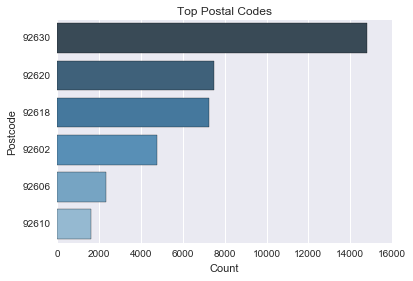

In [3]:
QUERY = ( 
    "SELECT tags.value, COUNT(*) as count "
    "FROM (SELECT * FROM nodes_tags UNION ALL SELECT * FROM ways_tags) tags "
    "WHERE tags.key='postcode' "
    "GROUP BY tags.value "
    "ORDER BY count DESC "
    "LIMIT 6;"
    )

print_graph(execute_query(QUERY), ['Postcode', 'Count'], "Top Postal Codes")

Top Postal Codes appear to be accurate with all codes beginning with "926--".

### City Count <a name="city-count"></a>

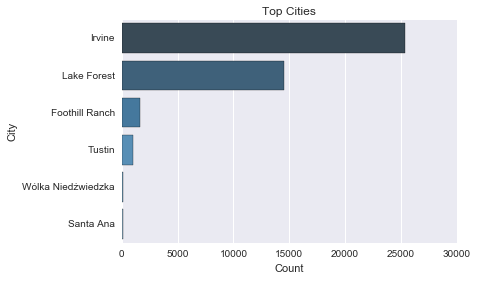

In [4]:
QUERY = ( 
    "SELECT tags.value, COUNT(*) as count "
    "FROM (SELECT * FROM nodes_tags UNION ALL SELECT * FROM ways_tags) tags "
    "WHERE tags.key ='city' "
    "GROUP BY tags.value "
    "ORDER BY count DESC "
    "LIMIT 6;"
    )

print_graph(execute_query(QUERY), ['City', 'Count'], "Top Cities")

Top cities appear to be accurate except for Wólka Niedźwiedzka. There is no city surrounding Irvine with any such name.

### File Sizes <a name="file-sizes"></a>
~~~
Irvine.osm .......... 91 MB
IrvineMaps.db ....... 58 MB
nodes.csv ........... 28 MB
nodes_tags.csv ...... 7 MB
ways.csv ............ 3 MB
ways_nodes.csv ...... 10 MB
ways_tags.csv ....... 11 MB
~~~

### Number of Nodes <a name="number-of-nodes"></a>

In [5]:
QUERY = "SELECT COUNT(*) FROM nodes;"

print_query(execute_query(QUERY), ['# of Nodes'])

# of Nodes
345345


### Number of Ways <a name="number-of-ways"></a>

In [6]:
QUERY = "SELECT COUNT(*) FROM ways;"

print_query(execute_query(QUERY), ['# of Ways'])

# of Ways
66056


### Unique Users <a name="unique-users"></a>

In [7]:
QUERY = (
    "SELECT COUNT(DISTINCT(uid)) "
    "FROM (SELECT uid FROM nodes UNION ALL SELECT uid FROM ways) uid; "
    )

print_query(execute_query(QUERY), ['Unique Users'])

Unique Users
2008


### Additional Analyses <a name="additional-analyses"></a>

##### Amenities <a name="amenities"></a>

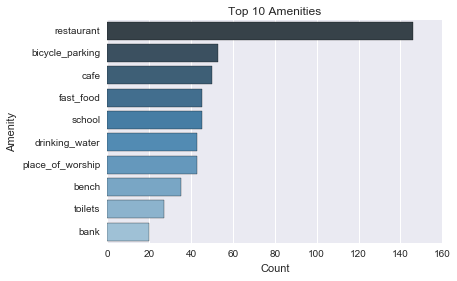

In [8]:
QUERY = (
    "SELECT value, COUNT(*) as num "
    "FROM nodes_tags "
    "WHERE key='amenity' "
    "GROUP BY value "
    "ORDER BY num DESC "
    "LIMIT 10;"
    )

print_graph(execute_query(QUERY), ['Amenity', 'Count'], "Top 10 Amenities")

Top Amenities appear to be mostly food-related. Bicycle parking is also popular; Irvine has a fairly flat and featureless topography making it easy for cyclists to traverse the city.

##### Types of Food <a name="types-of-food"></a>

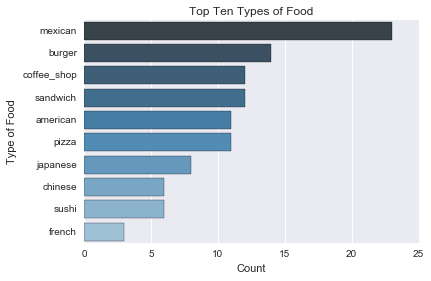

In [9]:
QUERY = (
    "SELECT nodes_tags.value, COUNT(*) as num "
    "FROM nodes_tags "
    "WHERE nodes_tags.key='cuisine' "
    "GROUP BY nodes_tags.value "
    "ORDER BY num DESC "
    "LIMIT 10; "
    )

print_graph(execute_query(QUERY), ['Type of Food', 'Count'], "Top Ten Types of Food")

Mexican food is highest in popularity; it is nearly doubles the second-highest type of food (burgers).

# Improvements <a name="improvements"></a>

For better and further analysis it is recommended to look further into:

#### Unicode Data
     
    The amount of unicode data appears to be minimal, but for more accurate data analysis it should be audited.
    
#### Wólka Niedźwiedzka 
    This city is listed as one of the top cities surrounding Irvine; Wólka Niedźwiedzka is a village in Poland and nowhere near Irvine. The tags associated with the city should be inspected and potentially not included in analysis. There are approximately 100 tags.

#### Cross Streets as Street Names

    There are multiple instances of cross streets being listed as a street name. These tags need to be inspected and fixed by hand.

Auditing all three recommended improvements would further enhance the accuracy of the analysis. The Unicode data contains accurate street names and postal codes whereas the Wólka Niedźwiedzka tags and the cross streets tags likely contain misleading and/or incorrect information.

The major downside to more auditing is additional manpower and time. Whereas the unicode data could be fixed via a program, the city tags of Wólka Niedźwiedzka and the Cross Streets names would have to be inspected and fixed by hand. The amount of information fixed from these three areas is not guarunteed to have a significant effect on the analysis, however it technically would be more accurate.

The graphs and data mentioned in this document are not representational of the entire database; there are additional areas to be explored and analyzed. Further exploration will most likely lead to discovery of additional dirty data requiring more manpower and time to fix. 